In [21]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import re
import seaborn as sns

In [3]:

def read_sparse_matrix(file):
    """
    reads in matrix via non-zero entry triples
    ex input:
    size: 3
    (0,0,123) (1,1,5) (2,1,-23)
    
    should output a matrix like:
    np.array([
        [123, 0,   0],
        [0,   5,   0],
        [0,   -23, 0]
    ])
    """
    m_size = int(file.readline().split()[1])
    m = np.zeros((m_size, m_size))
    for nnz_triple_str in file.readline().split():
        i, j, val = nnz_triple_str[1:-1].split(',')
        i = int(i)
        j = int(j)
        val = float(val)
        m[i,j] = val
    return m

def read_square_matrix(file):
    """
    function that reads in a square matrix from the file if the matrix is printed element by element separated by whitespace like:
    1 0 0
    2 1 0
    3 2 1
    """
    m = []
    cur_row = 1
    max_rows = 1    # placeholder value... since max_rows == # cols, we update this value in the loop
    while cur_row <= max_rows:
        line = file.readline()
        data = [float(x) for x in line.split()]
        m.append(data)
        if cur_row == 1:
            max_rows = len(data)    # number of rows = number of columns
        cur_row += 1
    return m


def read_data(f_path):
    data = {
        # 'N': [],
        'Q': [],
        # 'M': [],
        'policy_converged': [],
        # 'penalty_converged': []
    }
    with open(f_path) as f:
        while True:
            line = f.readline()
            if not line:
                return data
            if re.match("^N", line):
                data['N'].append(
                    # np.array(read_square_matrix(f))
                    read_sparse_matrix(f)
                )
            if re.match("^Q", line):
                data['Q'].append(
                    # np.array(read_square_matrix(f))
                    read_sparse_matrix(f)
                )
            if re.match("^M", line):
                data['M'].append(
                    # np.array(read_square_matrix(f))
                    read_sparse_matrix(f)
                )
            if re.match("^policy_converges", line):
                data['policy_converged'].append(
                    bool(int(f.readline()))
                )
            # if re.match("^penalty_converges", line):
            #     data['penalty_converged'].append(
            #         bool(int(f.readline()))
            #     )

In [ ]:
# loading the data from the files
data_outs = [
    './1000a.out','./1000b.out','./1000c.out','./1000d.out','./1000za.out','./1000zb.out',
]
data = {
    'Q':[],
    'policy_converged':[]
}

for f_name in data_outs:
    temp_data = read_data(f_name)
    data['Q'] += temp_data['Q'].copy()
    data['policy_converged'] += temp_data['policy_converged'].copy()
pd_data = pd.DataFrame(data)

In [15]:
sizes = [x.shape[0] for x in pd_data['Q']]
sum(sizes)

109094

In [17]:
# doing some calculations on the data
def inverse_with_default(x, default):
    try:
        return np.linalg.inv(x)
    except:
        return default
def min_val_with_default(x, default):
    try:
        return np.amin(x)
    except:
        return default
def lt_0_with_default(x, default):
    try:
        return np.count_nonzero(x < 0)
    except:
        return default

print("size...")
Q_size = [x.shape[0] for x in pd_data['Q']]
print("inverse calculations...")
Q_inv = [inverse_with_default(x, None) for x in pd_data['Q']]
Q_inv_min_val = [min_val_with_default(x, None) for x in Q_inv]
Q_inv_num_lt_0 = [lt_0_with_default(x, None) for x in Q_inv]
print("eigenvalues...")
eigenvalues = [np.linalg.eig(x)[0] for x in pd_data['Q']]
print("condition numbers...")
cond_num = [np.linalg.cond(x) for x in pd_data['Q']]

# many of the columns are just a scaled colum from the identity matrix (i.e.
# all rows of col i are 0 except for row i). We care about the interesting columns...
# i.e. those with more than 1 non-zero
print("off-diags...")
Q_num_off_diag_entries = [(np.count_nonzero(x) - np.shape(x)[0]) for x in pd_data['Q']]

# angles...
print("angles...")
thetas = []
min_theta = []
for x in pd_data['Q']:
    new_thetas = []
    for row in range(x.shape[0]):
        for col in range(x.shape[1]):
            val = x[row,col]
            if col == row or val == 0:
                continue
            m_inv_scaling_factor = x[col,col] / 2
            # if cos_theta is < -1 or > 1, then im pretty sure this element corresponds to a wall-ball collision
            # we don't really care about that case
            cos_theta = val / m_inv_scaling_factor
            if -1 > cos_theta or 1 < cos_theta:
                continue
            new_thetas.append(math.acos(cos_theta) * 180 / math.pi)
    thetas.append(new_thetas.copy())
    min_theta.append(min(new_thetas + [math.inf]))

print("stitching it all together...")

computed_data = pd_data.copy()
computed_data['Q_size'] = Q_size
computed_data['Q_inv'] = Q_inv
computed_data['Q_inv_min_val'] = Q_inv_min_val
computed_data['Q_inv_num_lt_0'] = Q_inv_num_lt_0
computed_data['eigenvalues'] = eigenvalues
computed_data['cond_num'] = cond_num
computed_data['Q_num_off_diag_entries'] = Q_num_off_diag_entries
computed_data['thetas'] = thetas
computed_data['min_theta'] = min_theta

size...
inverse calculations...
eigenvalues...
condition numbers...
off-diags...
angles...
stitching it all together...


In [22]:
computed_data

,Q,policy_converged,Q_size,Q_inv,Q_inv_min_val,Q_inv_num_lt_0,eigenvalues,cond_num,Q_num_off_diag_entries,thetas,min_theta
0,"[[3.1438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,62,"[[0.31808639226413893, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000e+00,0.0,"[3.1438, 3.1438, 3.1438, 3.1438, 3.1438, 3.143...",1.000000e+00,0,[],inf
1,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,62,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-3.650764e-16,8.0,"[6.287599999999977, 6.2876, 6.28760000000003, ...",1.000000e+00,8,"[90.00000000000027, 89.99999999999974, 90.0000...",90.000000
2,"[[3.1438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,62,"[[0.31808639226413893, 0.0, 0.0, 0.0, 0.0, 0.0...",0.000000e+00,0.0,"[3.1438, 3.1438, 3.1438, 3.1438, 3.1438, 3.143...",1.000000e+00,0,[],inf
3,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,62,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-3.650764e-16,8.0,"[6.287599999999977, 6.2876, 6.28760000000003, ...",1.000000e+00,8,"[90.00000000000027, 89.99999999999974, 90.0000...",90.000000
4,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True,126,"[[0.15904319613206946, 0.0, 0.0, 0.0, 0.0, 0.0...",-2.718933e+04,24.0,"[6.287599999999997, 3.1438000000000015, 12.575...",1.934143e+06,32,"[90.00000000000027, 89.99999999999973, 90.0000...",45.000059
...,...,...,...,...,...,...,...,...,...,...,...
531,"[[6.2876, -1.0026, -0.7085, 0.0, 0.0, 0.0, 0.0...",True,7,"[[0.16356285055033307, 0.02069384018103827, 0....",-1.557978e-01,8.0,"[11.127695086283229, 7.290199999999999, 5.8724...",5.974247e+00,12,"[108.59722567223619, 103.02429587463078, 108.5...",5.573022
532,"[[6.2876, 0.767592, 0.0, 0.0], [0.767592, 6.28...",True,4,"[[0.16144937234992776, -0.019709785390423333, ...",-1.970979e-02,4.0,"[7.055192, 5.520008, 7.055192, 5.520008]",1.278113e+00,4,"[75.86776853699584, 75.86776853699584, 75.8677...",75.867769
533,"[[6.2876, 0.0], [0.0, 6.2876]]",True,2,"[[0.15904319613206946, 0.0], [0.0, 0.159043196...",0.000000e+00,0.0,"[6.2876, 6.2876]",1.000000e+00,0,[],inf
534,"[[6.2876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",False,1763,None,NaN,NaN,"[(12.19601132245348+0j), (5.195769718101401+0j...",5.769280e+18,20680,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000


<AxesSubplot: xlabel='Q_size', ylabel='Q_inv_num_lt_0'>

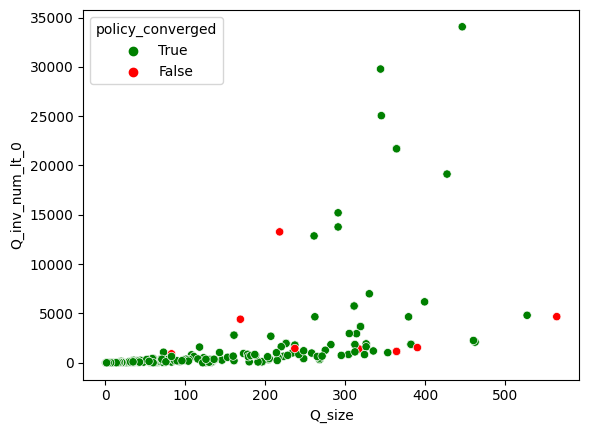

In [36]:
# data visualization...
# number of negs in the inverse
# sns.scatterplot(data=computed_data, x=computed_data.Q_size , y='Q_inv_num_lt_0', hue='policy_converged', palette=["green", "red"])
sns.scatterplot(data=computed_data[computed_data.Q_size < 600], x=computed_data.Q_size , y='Q_inv_num_lt_0', hue='policy_converged', palette=["green", "red"])

<AxesSubplot: ylabel='min_theta'>

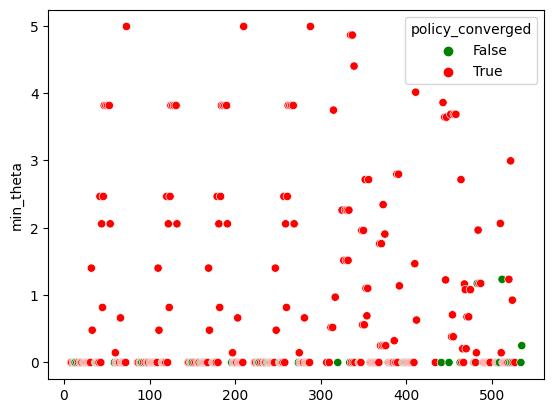

In [41]:
# min angle
# sns.scatterplot(data=computed_data, x=computed_data.index, y='min_theta', hue='policy_converged', palette=["green", "red"])
# sns.scatterplot(data=computed_data[computed_data.min_theta < 25], x=computed_data[computed_data.min_theta < 25].index, y='min_theta', hue='policy_converged', palette=["green", "red"])
sns.scatterplot(data=computed_data[computed_data.min_theta < 5], x=computed_data[computed_data.min_theta < 5].index, y='min_theta', hue='policy_converged', palette=["green", "red"])


In [ ]:
# what does the distribution of angles look like in the non-converging cases?
computed_data[computed_data.policy_converged == False]

In [8]:
A = np.array([
       [ 6.28760e+00, -2.13713e-06,  2.22300e+00,  2.22300e+00, 1.10519e-07,  0.00000e+00],
       [-2.13713e-06,  6.28760e+00,  2.22300e+00,  2.22300e+00, 0.00000e+00,  4.16374e-06],
       [ 2.22300e+00,  2.22300e+00,  6.28760e+00,  0.00000e+00, 2.22300e+00,  2.22300e+00],
       [ 2.22300e+00,  2.22300e+00,  0.00000e+00,  6.28760e+00, 2.22300e+00,  2.22300e+00],
       [ 1.10519e-07,  0.00000e+00,  2.22300e+00,  2.22300e+00, 6.28760e+00, -2.13713e-06],
       [ 0.00000e+00,  4.16374e-06,  2.22300e+00,  2.22300e+00, -2.13713e-06,  6.28760e+00]
])

print(np.linalg.eigvals(A))

for row in range(A.shape[0]):
       for col in range(A.shape[1]):
              val = A[row,col]
              if col >= row or val == 0:
                     continue
              m_inv_scaling_factor = 6.28760 / 2
              cos_theta = val / m_inv_scaling_factor
              # print(row, col, cos_theta)
              print(f"between {row}, {col}: {math.acos(cos_theta) * 180 / math.pi}")



[6.50168865e-06 1.25751935e+01 6.28759492e+00 6.28760081e+00
 6.28760427e+00 6.28760000e+00]
between 1, 0: 90.00003894921092
between 2, 0: 45.00005924663773
between 2, 1: 45.00005924663773
between 3, 0: 45.00005924663773
between 3, 1: 45.00005924663773
between 4, 0: 89.99999798579036
between 4, 2: 45.00005924663773
between 4, 3: 45.00005924663773
between 5, 1: 89.99992411580604
between 5, 2: 45.00005924663773
between 5, 3: 45.00005924663773
between 5, 4: 90.00003894921092
